### **ICESat数据预处理**

In [31]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pyrsimg import readTiff, imgShow, second_to_dyr


In [32]:
path_glah14 = 'data/laser/GLAH14_634_2109_002_0351_0_01_0001.H5'
path_rsimg = 'data/rsimg/s2_gla_region_20220707.tif'


In [33]:
!h5ls $path_glah14/Data_40HZ
# !h5ls $path_glah14/Data_1HZ/Geolocation/i_track
# !h5ls $path_glah14/Data_40HZ/Elevation_Surfaces


Atmosphere               Group
DS_DEMhiresArElv         Dataset {9/Inf}
DS_PeakNumber            Dataset {6/Inf}
DS_UTCTime_40            Dataset {1137320/Inf}
Elevation_Angles         Group
Elevation_Corrections    Group
Elevation_Flags          Group
Elevation_Offsets        Group
Elevation_Surfaces       Group
Geolocation              Group
Geophysical              Group
Quality                  Group
Reflectivity             Group
Time                     Group
Transmit_Energy          Group
Waveform                 Group


In [34]:
vars_glah14 = {}
with h5py.File(path_glah14,'r') as glah14:
    vars_glah14['lat'] = glah14['Data_40HZ/Geolocation/d_lat'][:]
    vars_glah14['lon'] = glah14['Data_40HZ/Geolocation/d_lon'][:]
    vars_glah14['time'] = glah14['Data_40HZ/Time/d_UTCTime_40'][:]
    vars_glah14['elev'] = glah14['Data_40HZ/Elevation_Surfaces/d_elev'][:]
    
    vars_glah14['satu_cor'] = glah14['Data_40HZ/Elevation_Corrections/d_satElevCorr'][:]
    
    vars_glah14['satu_flg'] = glah14['Data_40HZ/Quality/sat_corr_flg'][:]  ## 0 -> good
    vars_glah14['elev_flg'] = glah14['Data_40HZ/Quality/elev_use_flg'][:]
    vars_glah14['att_flg'] = glah14['Data_40HZ/Quality/sigma_att_flg'][:]

    vars_glah14['delta_ellip'] = glah14['Data_40HZ/Geophysical/d_deltaEllip'][:]



In [35]:
rsimg = readTiff(path_rsimg)
print(rsimg.array.shape)


(870, 1070, 6)


In [36]:
vars_glah14['time'][0:10]
vars_glah14['time_dyr'] = second_to_dyr(vars_glah14['time'])
vars_glah14['time_dyr'][0:10]


array([2004.83429178, 2004.83429178, 2004.83429178, 2004.83429178,
       2004.83429178, 2004.83429178, 2004.83429178, 2004.83429179,
       2004.83429179, 2004.83429179])

In [ ]:
print(vars_glah14['lat'].shape)
ids = np.where((vars_glah14['lat']>30.38) 
               & (vars_glah14['lat']<30.77)
               & (vars_glah14['lon']<95.04)
               & (vars_glah14['lon']>94.56)
               & (vars_glah14['elev'] < 8848))

for key in vars_glah14:
    vars_glah14[key] = vars_glah14[key][ids]
print(vars_glah14['lat'].shape)


(1137320,)
(246,)


In [ ]:
ids_2 = np.where((vars_glah14['elev_flg'] == 0) 
                 & (vars_glah14['att_flg']==0)
                 & (vars_glah14['satu_flg']<2))

for key in vars_glah14:
    vars_glah14[key] = vars_glah14[key][ids_2]
print(vars_glah14['lat'].shape)



(215,)


In [45]:
vars_glah14['elev_cor'] = vars_glah14['elev'] + vars_glah14['satu_cor']


In [46]:
vars_glah14['elev_cor'] = vars_glah14['elev_cor'] - vars_glah14['delta_ellip']


(6200.0, 6230.0)

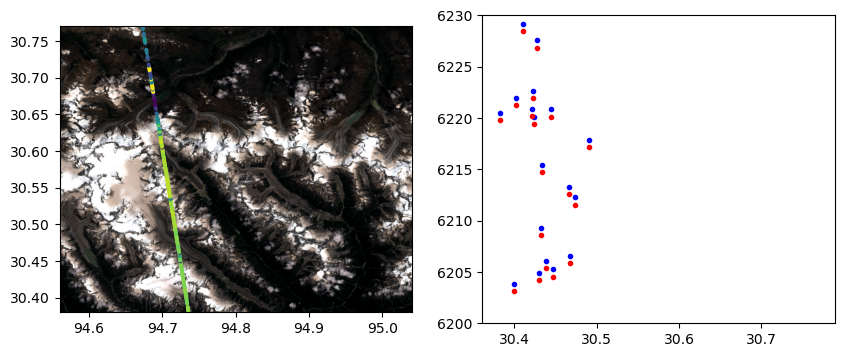

In [55]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
imgShow(rsimg.array, extent=rsimg.geoextent, clip_percent=5, ax=ax[0])
ax[0].scatter(x=vars_glah14['lon'], y=vars_glah14['lat'], c=vars_glah14['elev_cor'], s=3.5)
ax[1].plot(vars_glah14['lat'], vars_glah14['elev'], 'b.')
ax[1].plot(vars_glah14['lat'], vars_glah14['elev_cor'], 'r.')
ax[1].set_ylim(6200,6230)


In [ ]:
## write out to .h5 file.
file_out = 'data/laser/isat_gla_region.h5'
with h5py.File(file_out, "w") as f_out:
    [f_out.create_dataset(key, data=vars_glah14[key]) for key in vars_glah14.keys()]
    print('written file:', (file_out))



written file: data/laser/isat_gla_region.h5
